In [1]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 20.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchmetrics
from torchmetrics import Dice, JaccardIndex
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2 # np.array -> torch.tensor
import os
from tqdm import tqdm
from glob import glob

In [3]:
# Mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Prepare Data**

100%|██████████| 3929/3929 [00:00<00:00, 1027331.24it/s]


(256, 256) 0
[0]


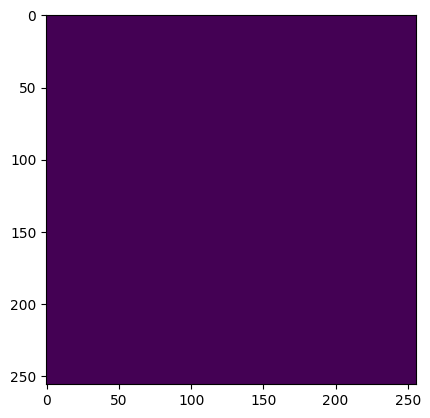

In [4]:
mask_files = glob('/content/gdrive/MyDrive/Brain_Tumor/input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')
image_files = [file.replace("_mask", "") for file in tqdm(mask_files)]

# Create a dataframe
df = pd.DataFrame({
    "image_path": image_files,
    "mask_path": mask_files,
})

# Read mask
mask = cv2.imread(mask_files[0], cv2.COLOR_BGR2GRAY)
plt.imshow(mask);
print(mask.shape, cv2.IMREAD_GRAYSCALE)
print(np.unique(mask))

(256, 256, 3)


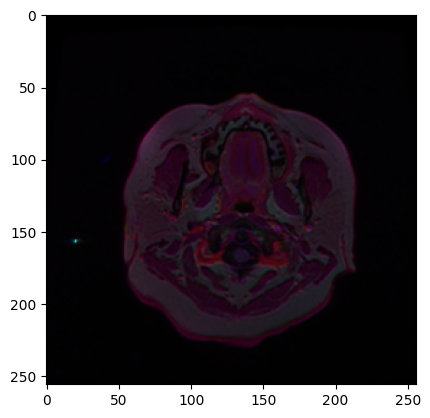

In [5]:
# Read image
image = cv2.imread(image_files[0])
plt.imshow(image)
print(image.shape)

**Split train, test, val dataset**

In [6]:
train_df, val_df = train_test_split(df, test_size=0.1, random_state=0)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, test_size=0.15, random_state=0)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(3005, 2)
(393, 2)
(531, 2)


**Transform Data**

In [7]:
train_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.ShiftScaleRotate(
            shift_limit=0.2,
            scale_limit=0.2,
            rotate_limit=30,
            p=0.5
        ),
        A.RGBShift(
            r_shift_limit=25,
            g_shift_limit=25,
            b_shift_limit=25,
            p=0.5
        ),
        A.RandomBrightnessContrast(
            brightness_limit=0.3,
            contrast_limit=0.3,
            p=0.5
        ),
        A.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225),
            max_pixel_value=255.0
        ),
        ToTensorV2(),
    ]
)
val_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225),
        ),
        ToTensorV2(), # numpy.array -> torch.tensor (B, 3, H, W)
    ]
)
test_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225),
        ),
        ToTensorV2(), # numpy.array -> torch.tensor (B, 3, H, W)

    ]
)

**Load Data**

In [8]:
class Load_Data(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 0])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.df.iloc[idx, 1])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

        mask[mask == 255] = 1

        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            transformed_image = transformed["image"]
            transformed_mask = transformed["mask"]
        return transformed_image, transformed_mask

In [9]:
train_dataset = Load_Data(train_df, transform=train_transform)
val_dataset = Load_Data(val_df, transform=val_transform)
test_dataset = Load_Data(test_df, transform=test_transform)

**Test Dataload**

In [10]:
image, mask = train_dataset.__getitem__(0)
print(image.shape, mask.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


In [11]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

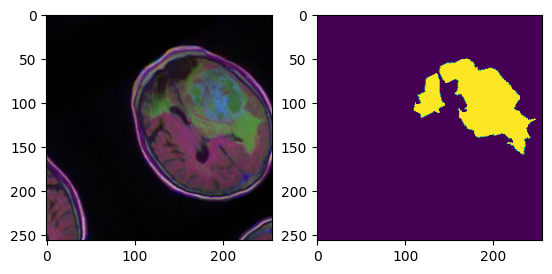

In [12]:
plt.subplot(1, 2, 1)
plt.imshow(unorm(image).permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.show()

**Mô hình Unet**

In [13]:
def unet_block(in_channels, out_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, 3, 1, 1),
      nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, 3, 1, 1),
      nn.ReLU()
  )

class UNet(nn.Module):
  def __init__(self, n_classes):
    super().__init__()
    self.n_classes = n_classes
    self.downsample = nn.MaxPool2d(2)
    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
    self.block_down1 = unet_block(3, 64)
    self.block_down2 = unet_block(64, 128)
    self.block_down3 = unet_block(128, 256)
    self.block_down4 = unet_block(256, 512)
    self.block_neck = unet_block(512, 1024)
    self.block_up1 = unet_block(1024+512, 512)
    self.block_up2 = unet_block(512+256, 256)
    self.block_up3 = unet_block(256+128, 128)
    self.block_up4 = unet_block(128+64, 64)

    self.conv_cls = nn.Conv2d(64, self.n_classes, 1) # (B, n_class, H, W)

  def forward(self, x):
    x1 = self.block_down1(x)
    x = self.downsample(x1)
    x2 = self.block_down2(x)
    x = self.downsample(x2)
    x3 = self.block_down3(x)
    x = self.downsample(x3)
    x4 = self.block_down4(x)
    x = self.downsample(x4)

    x = self.block_neck(x)

    x = torch.cat([x4, self.upsample(x)], dim=1)
    x = self.block_up1(x)
    x = torch.cat([x3, self.upsample(x)], dim=1)
    x = self.block_up2(x)
    x = torch.cat([x2, self.upsample(x)], dim=1)
    x = self.block_up3(x)
    x = torch.cat([x1, self.upsample(x)], dim=1)
    x = self.block_up4(x)

    x = self.conv_cls(x)
    return x

**Test model**

In [14]:
model = UNet(1)

trainsize = 256
x = torch.rand(4, 3, trainsize, trainsize)
print("Input shape = ", x.shape)
y = model(x)
print("Output shape = ", y.shape)

Input shape =  torch.Size([4, 3, 256, 256])
Output shape =  torch.Size([4, 1, 256, 256])


In [15]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [16]:
#accuracy fn
def accuracy_function(preds, targets):
    preds_flat = preds.flatten()
    targets_flat = targets.flatten()
    acc = torch.sum(preds_flat == targets_flat)
    return acc/targets_flat.shape[0]

In [17]:
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#load data
batch_size = 16
n_workers = os.cpu_count()
print("num_workers =", n_workers)

trainloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_workers
)

valloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=n_workers
)

testloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=n_workers
)

dataloader_dict = {"train": trainloader, "val": valloader}

#model
model = UNet(1).to(device)

#loss
criterior = nn.BCEWithLogitsLoss()

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
num_epochs = 50

#metrics
dice_fn = torchmetrics.Dice(num_classes=2, average="macro").to(device)
iou_fn = torchmetrics.JaccardIndex(num_classes=2, task="binary", average="macro").to(device)

#meter
train_acc_meter = AverageMeter()
train_loss_meter = AverageMeter()
train_dice_meter = AverageMeter()
train_iou_meter = AverageMeter()
val_iou_meter = AverageMeter()
val_dice_meter = AverageMeter()
val_loss_meter =  AverageMeter()

meters = {
    "train_acc_meter": train_acc_meter,
    "train_loss_meter": train_loss_meter,
    "train_dice_meter": train_dice_meter,
    "train_iou_meter": train_iou_meter,
    "val_iou_meter": val_iou_meter,
    "val_dice_meter": val_dice_meter,
    "val_loss_meter": val_loss_meter
}

train_loss_history = []
val_loss_history = []
val_dice_history = []
val_iou_history = []

history = {
    "train_loss_history": train_loss_history,
    "val_loss_history": val_loss_history,
    "val_dice_history": val_dice_history,
    "val_iou_history": val_iou_history
}


num_workers = 2


In [18]:
def train_model(model, optimizer, criterior, num_epochs):

  best_val_loss = float('inf')
  best_params = None
  best_params_path = "/content/gdrive/MyDrive/My_Project/UNet/model_UNet1.pth"

  for epoch in range(num_epochs):
      # Train
      model.train()
      train_acc_meter.reset()
      train_loss_meter.reset()
      train_dice_meter.reset()
      train_iou_meter.reset()

      for inputs, labels in tqdm(trainloader):
        optimizer.zero_grad()
        n = inputs.shape[0]
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()
        outputs = model(inputs)
        outputs = outputs.squeeze() # -> logit (-vc, +vc)
        train_loss = criterior(outputs, labels)
        train_loss.backward()
        optimizer.step()

        with torch.no_grad():
          outputs_mask = outputs.sigmoid().round().long() # -> mask (0, 1)
          train_dice_score = dice_fn(outputs_mask, labels.long())
          train_iou_score = iou_fn(outputs_mask, labels.long())
          train_accuracy = accuracy_function(outputs_mask, labels.long())

          train_loss_meter.update(train_loss.item(), n)
          train_iou_meter.update(train_iou_score.item(), n)
          train_dice_meter.update(train_dice_score.item(), n)
          train_acc_meter.update(train_accuracy.item(), n)

          history["train_loss_history"].append(train_loss_meter.avg)

      # Validation
      model.eval()
      val_iou_meter.reset()
      val_dice_meter.reset()
      val_loss_meter.reset()
      with torch.no_grad():
        for inputs, labels in tqdm(valloader):
          optimizer.zero_grad()
          n = inputs.shape[0]
          inputs = inputs.to(device).float()
          labels = labels.to(device).float()
          outputs = model(inputs).to(device)
          outputs = outputs.squeeze() # -> logit (-vc, +vc)
          val_loss = criterior(outputs, labels)
          outputs_mask = outputs.sigmoid().round().long()
          val_dice_score = dice_fn(outputs_mask, labels.long())
          val_iou_score = iou_fn(outputs_mask, labels.long())

          val_dice_meter.update(val_dice_score.item(), n)
          val_iou_meter.update(val_iou_score.item(), n)
          val_loss_meter.update(val_loss.item(), n)

        history["val_loss_history"].append(val_loss_meter.avg)
        history["val_dice_history"].append(val_dice_meter.avg)
        history["val_iou_history"].append(val_iou_meter.avg)

      # Lưu lại bộ tham số tốt nhất
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          best_params = model.state_dict()

      print(f"\nEpoch {epoch+1}/{num_epochs}:")
      print(f"Train Loss: {train_loss_meter.avg:.4f}", end=' ')
      print(f"Train Acc: {train_acc_meter.avg:.4f}", end=' ')
      print(f"Train Dice: {train_dice_meter.avg:.4f}", end=' ')
      print(f"Train IoU: {train_iou_meter.avg:.4f}", end=' ')
      print(f"Val Loss: {val_loss_meter.avg:.4f}",end=' ')
      print(f"Val Dice: {val_dice_meter.avg:.4f}", end=' ')
      print(f"Val IoU: {val_iou_meter.avg:.4f}")

  torch.save(best_params, best_params_path)

In [19]:
train_model(model, optimizer, criterior, num_epochs)

100%|██████████| 25/25 [00:07<00:00,  3.29it/s]



Epoch 20/30:
Train Loss: 0.0133 Train Acc: 0.9956 Train Dice: 0.8753 Train IoU: 0.6196 Val Loss: 0.0083 Val Dice: 0.9133 Val IoU: 0.7130


100%|██████████| 25/25 [00:07<00:00,  3.22it/s]



Epoch 21/30:
Train Loss: 0.0113 Train Acc: 0.9962 Train Dice: 0.8913 Train IoU: 0.6605 Val Loss: 0.0080 Val Dice: 0.9187 Val IoU: 0.7288


100%|██████████| 25/25 [00:07<00:00,  3.18it/s]



Epoch 22/30:
Train Loss: 0.0119 Train Acc: 0.9960 Train Dice: 0.8863 Train IoU: 0.6494 Val Loss: 0.0086 Val Dice: 0.9102 Val IoU: 0.7048


100%|██████████| 25/25 [00:07<00:00,  3.26it/s]



Epoch 23/30:
Train Loss: 0.0106 Train Acc: 0.9964 Train Dice: 0.8977 Train IoU: 0.6754 Val Loss: 0.0083 Val Dice: 0.9167 Val IoU: 0.7254


100%|██████████| 25/25 [00:07<00:00,  3.30it/s]



Epoch 24/30:
Train Loss: 0.0110 Train Acc: 0.9965 Train Dice: 0.8996 Train IoU: 0.6811 Val Loss: 0.0080 Val Dice: 0.9170 Val IoU: 0.7253


100%|██████████| 25/25 [00:07<00:00,  3.28it/s]



Epoch 25/30:
Train Loss: 0.0101 Train Acc: 0.9966 Train Dice: 0.9047 Train IoU: 0.6937 Val Loss: 0.0082 Val Dice: 0.9097 Val IoU: 0.7041


100%|██████████| 25/25 [00:07<00:00,  3.15it/s]



Epoch 26/30:
Train Loss: 0.0114 Train Acc: 0.9963 Train Dice: 0.9011 Train IoU: 0.6825 Val Loss: 0.0084 Val Dice: 0.8964 Val IoU: 0.6690


100%|██████████| 25/25 [00:07<00:00,  3.23it/s]



Epoch 27/30:
Train Loss: 0.0104 Train Acc: 0.9965 Train Dice: 0.9038 Train IoU: 0.6922 Val Loss: 0.0064 Val Dice: 0.9291 Val IoU: 0.7614


100%|██████████| 25/25 [00:07<00:00,  3.30it/s]



Epoch 28/30:
Train Loss: 0.0098 Train Acc: 0.9967 Train Dice: 0.9123 Train IoU: 0.7115 Val Loss: 0.0078 Val Dice: 0.9206 Val IoU: 0.7353


100%|██████████| 25/25 [00:07<00:00,  3.31it/s]



Epoch 29/30:
Train Loss: 0.0103 Train Acc: 0.9966 Train Dice: 0.9069 Train IoU: 0.7005 Val Loss: 0.0062 Val Dice: 0.9348 Val IoU: 0.7746


100%|██████████| 25/25 [00:07<00:00,  3.23it/s]



Epoch 30/30:
Train Loss: 0.0094 Train Acc: 0.9968 Train Dice: 0.9155 Train IoU: nan Val Loss: 0.0079 Val Dice: 0.9191 Val IoU: 0.7333


In [20]:
print(history["val_loss_history"])

[0.029533340524569268, 0.026586299442209815, 0.030898320431757064, 0.026890142824330176, 0.018973880144115773, 0.020381652189622474, 0.017482743257865235, 0.016394901748760852, 0.015308842065912357, 0.014925985616624697, 0.01505823028641196, 0.013086332597132327, 0.011046960384113378, 0.01022883827866792, 0.01054210411135875, 0.010672142704280506, 0.008880178912414792, 0.00967349314116624, 0.008721200099959022, 0.008349676535621228, 0.007956380790879158, 0.008622411666343192, 0.008346663052737523, 0.008013760718118882, 0.008225158786634575, 0.008423361206710405, 0.006424361956305802, 0.007845447790327911, 0.006160879016672581, 0.007897129215112871]


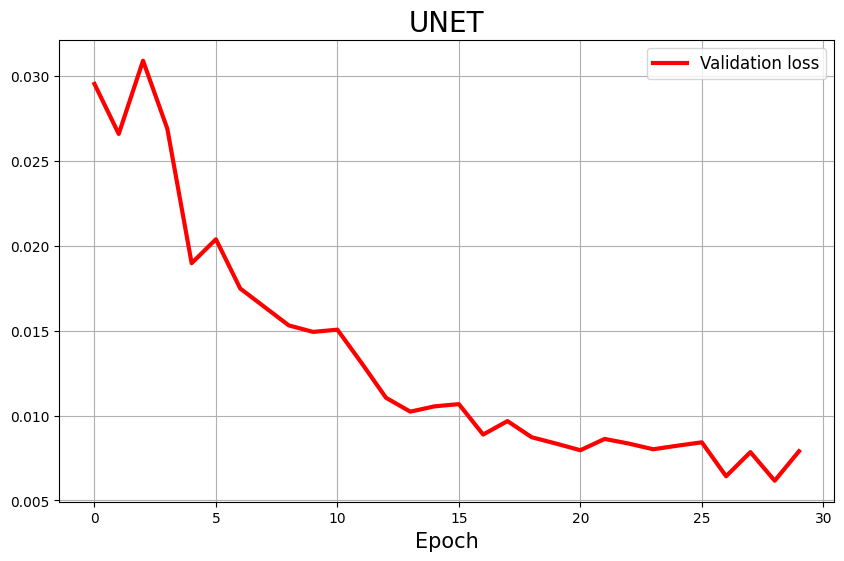

In [40]:
def plot_dice_history(model_name, metrics, num_epochs):

    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, metrics, label='Validation loss', lw=3, c="r")

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)

    plt.grid()
    plt.show()

plot_dice_history('UNET', history["val_loss_history"], num_epochs)

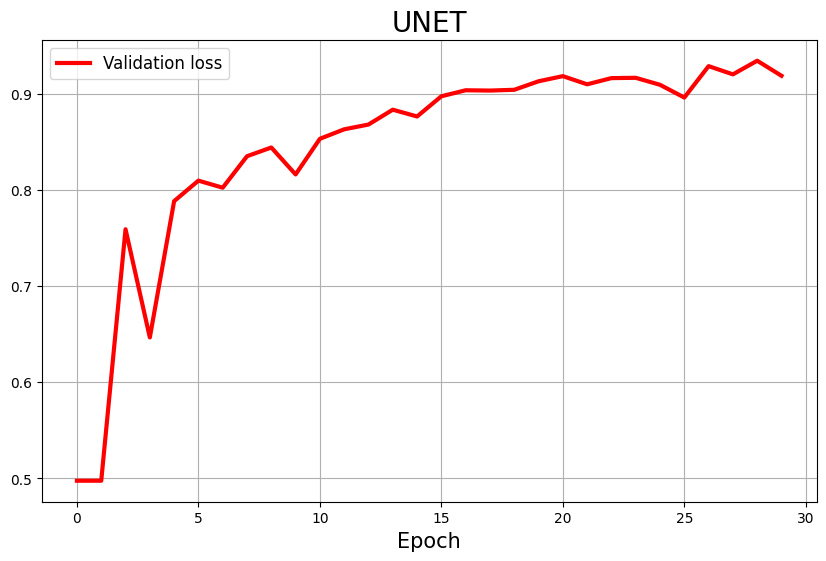

In [41]:
plot_dice_history('UNET', history["val_dice_history"], num_epochs)

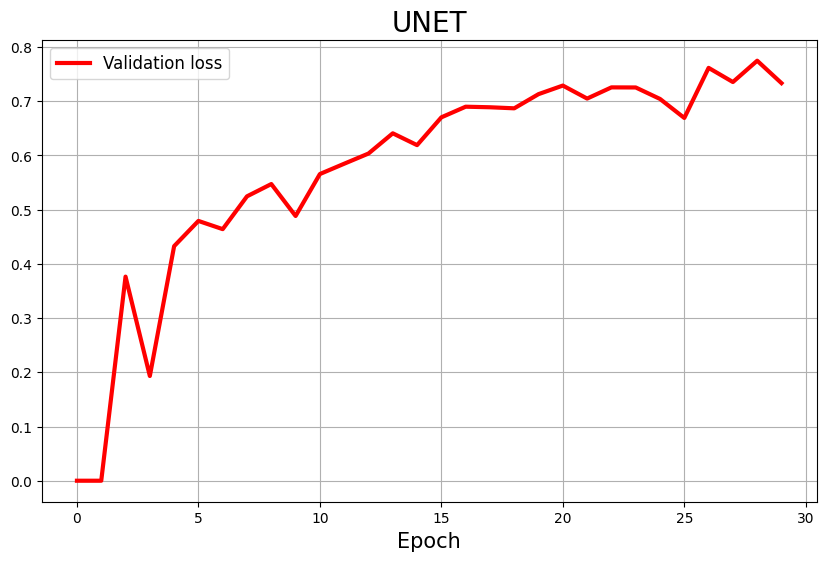

In [42]:
plot_dice_history('UNET', history["val_iou_history"], num_epochs)

In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(1).to(device)
model.load_state_dict(torch.load("/content/gdrive/MyDrive/My_Project/UNet/model_UNet1.pth"))
test_iou_meter = AverageMeter()
test_dice_meter = AverageMeter()
with torch.no_grad():
    for batch_id, (x, y) in enumerate(tqdm(testloader), start=1):
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).float()
        y_hat = model(x)
        y_hat = y_hat.squeeze()
        y_hat_mask = y_hat.sigmoid().round().long()
        dice_score = dice_fn(y_hat_mask, y.long())
        iou_score = iou_fn(y_hat_mask, y.long())
        test_dice_meter.update(dice_score.item(), n)
        test_iou_meter.update(iou_score.item(), n)
print("TEST: IoU = {}, dice = {}".format(test_iou_meter.avg, test_dice_meter.avg))

100%|██████████| 34/34 [00:10<00:00,  3.33it/s]

TEST: IoU = 0.7242922153176561, dice = 0.9172923775940516


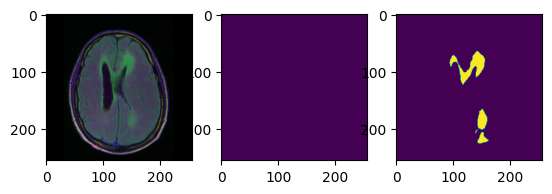

In [54]:
import random

model.eval()
idx = random.randint(200, 400)
with torch.no_grad():
    x, y = test_dataset[idx]
    # print(x.shape, y.shape) (C, H, W) -> (1, C, H, W) -> model
    x = x.to(device).float().unsqueeze(0)
    y_hat = model(x).squeeze() #(1, 1, H, W) -> (H, W)
    y_hat_mask = y_hat.sigmoid().round().long()
    # x, y, y_hat_mask
    plt.subplot(1, 3, 1)
    plt.imshow(unorm(x.squeeze().cpu()).permute(1, 2, 0)) # x (GPU) -> x(CPU)
    plt.subplot(1, 3, 2)
    plt.imshow(y)
    plt.subplot(1, 3, 3)
    plt.imshow(y_hat_mask.cpu())